In [47]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

%matplotlib inline


In [48]:
species_info = pd.read_csv('species_info.csv', encoding='utf-8')
species_info.head()


,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [49]:
observations = pd.read_csv('observations.csv', encoding='utf-8')
observations.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [50]:
# Checks the dimensions of the dataset
print(f'species_info shape: {species_info.shape}')
print(f'observations shape: {observations.shape}')

species_info shape: (5824, 4)
observations shape: (23296, 3)


In [51]:
#  View the number of categories in the dataset
print(f'nnumber of categories: {species_info.category.nunique()}')
print(f'categories: {species_info.category.unique()}')

nnumber of categories: 7
categories: ['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fish' 'Vascular Plant'
 'Nonvascular Plant']


In [52]:
# Views the count of categories in the dataset
species_info.groupby('category').size()

category
Amphibian              80
Bird                  521
Fish                  127
Mammal                214
Nonvascular Plant     333
Reptile                79
Vascular Plant       4470
dtype: int64

In [53]:
# View the conservation status column
print(f'number of conservation statuses: {species_info.conservation_status.nunique()}')
print(f'unique conservation statuses: {species_info.conservation_status.unique()}')

number of conservation statuses: 4
unique conservation statuses: [nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']


In [54]:
# Check the number of nan values, which are species without concerns
print(f'na values: {species_info.conservation_status.isna().sum()}')
print(species_info.groupby('conservation_status').size())

na values: 5633
conservation_status
Endangered             16
In Recovery             4
Species of Concern    161
Threatened             10
dtype: int64


In [55]:
# Checks the number of national parks
print(f'number of parks: {observations.park_name.nunique()}')
print(f'unique park: {observations.park_name.unique()}')

number of parks: 4
unique park: ['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


In [56]:
# Print the total number of observations
print(f'number of observations: {observations.observations.sum()}')

number of observations: 3314739


In [57]:
# Convert the nan values to 'No Intervention'
species_info.fillna('No Intervention', inplace=True)
species_info.groupby('conservation_status').size()

conservation_status
Endangered              16
In Recovery              4
No Intervention       5633
Species of Concern     161
Threatened              10
dtype: int64

In [58]:
# Check the different categories that are in the conservation status except for ones that do not require an intervention
conservationCategory = species_info[species_info.conservation_status != 'No Intervention']\
    .groupby(['conservation_status', 'category'])['scientific_name']\
    .count()\
    .unstack()
conservationCategory

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,7.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,1.0,NaN,NaN,NaN
Species of Concern,4.0,72.0,4.0,28.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


Text(0, 0.5, 'Number of Species')

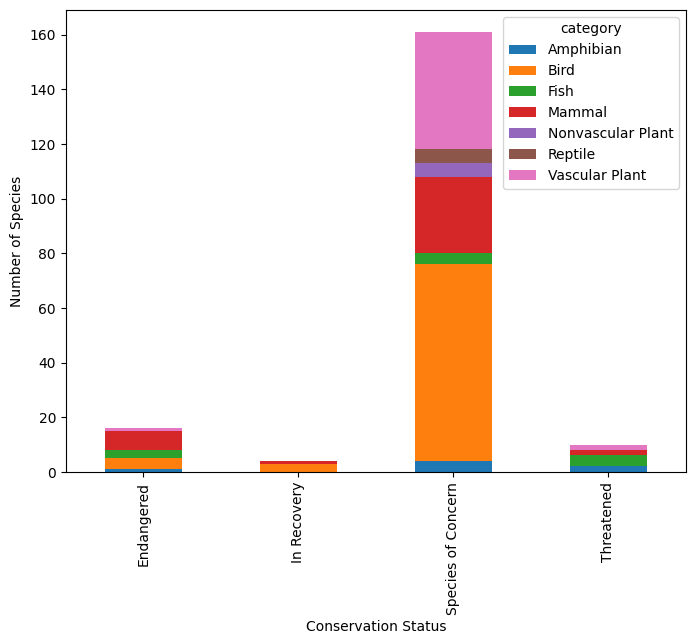

In [59]:
ax = conservationCategory.plot(kind = 'bar', figsize=(8,6), stacked=True)
ax.set_xlabel('Conservation Status')
ax.set_ylabel('Number of Species')

In [69]:
# Creates a new column to see which species is the more likely to be endangered
species_info['is_protected'] = species_info.conservation_status != 'No Intervention'

In [91]:
# Uses the new category to show each category and their protection status
category_counts = species_info.groupby(['category', 'is_protected'])\
    .scientific_name.nunique()\
    .reset_index()\
    .pivot(columns='is_protected',
            index='category',
            values='scientific_name')\
    .reset_index()
category_counts.columns = ['category', 'not_protected', 'protected']
category_counts

,category,not_protected,protected
0,Amphibian,72,7
1,Bird,413,75
2,Fish,115,11
3,Mammal,146,30
4,Nonvascular Plant,328,5
5,Reptile,73,5
6,Vascular Plant,4216,46


In [93]:
# Calculate the protection rate for each category
category_counts['percent_protected'] = category_counts.protected / (category_counts.protected + category_counts.not_protected) * 100
category_counts

,category,not_protected,protected,percent_protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,115,11,8.730159
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


In [95]:
# Chi square tests will be used to see if species have a significant difference in conservation status rates
# Mammals and birds will be used to view this relationship -- not a significant relationship: 0.69 > 0.05
from scipy.stats import chi2_contingency

contingency1 = [[30, 146],
                [75, 413]]
chi2_contingency(contingency1)

Chi2ContingencyResult(statistic=0.1617014831654557, pvalue=0.6875948096661336, dof=1, expected_freq=array([[ 27.8313253, 148.1686747],
       [ 77.1686747, 410.8313253]]))

In [97]:
# Use chi square test to view the relationship between reptiles and mammals
# significant relationship: 0.03 < 0.05
contingency2 = [[30, 146],
                [5, 75]]
chi2_contingency(contingency2)

Chi2ContingencyResult(statistic=4.554654757007698, pvalue=0.0328293818820224, dof=1, expected_freq=array([[ 24.0625, 151.9375],
       [ 10.9375,  69.0625]]))

In [98]:
# Use the animals' common names to see the count of each animal
from itertools import chain
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

common_Names = species_info[species_info.category == 'Mammal'].common_names.apply(remove_punctuations).str.split().tolist()
common_Names[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison', 'Bison'],
 ['Aurochs',
  'Aurochs',
  'Domestic',
  'Cattle',
  'Feral',
  'Domesticated',
  'Cattle'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Sheep', 'Sheep', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [99]:
# Remove the duplicate words in each row because they shouldn't be counted multiple times per species
clean = []

for name in common_Names:
    name = list(dict.fromkeys(name))
    clean.append(name)

clean[:6]

[['Gappers', 'RedBacked', 'Vole'],
 ['American', 'Bison'],
 ['Aurochs', 'Domestic', 'Cattle', 'Feral', 'Domesticated'],
 ['Domestic', 'Sheep', 'Mouflon', 'Red', 'Feral'],
 ['Wapiti', 'Or', 'Elk'],
 ['WhiteTailed', 'Deer']]

In [100]:
# Condense the list
res = list(chain.from_iterable(i if isinstance(i, list) else [i] for i in clean))
res[:6]

['Gappers', 'RedBacked', 'Vole', 'American', 'Bison', 'Aurochs']

In [101]:
# Count the number of occurences of each name
counted = []

for i in res:
    x = res.count(i)
    counted.append((i,x))

pd.DataFrame(set(counted), columns=['Name', 'Count']).sort_values('Count', ascending=False).head(10)

,Name,Count
197,Bat,23
36,Shrew,18
33,Myotis,17
106,Mouse,16
23,Chipmunk,13
187,American,12
176,Squirrel,12
199,Eastern,11
172,Vole,11
146,Mountain,10


In [102]:
# Use a boolean to see which rows are referring to a type of bat
species_info['is_bat'] = species_info.common_names.str.contains(r'\bBat', regex=True)
species_info.head(10)

,category,scientific_name,common_names,conservation_status,is_protected,is_bat
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,No Intervention,False,False
1,Mammal,Bos bison,"American Bison, Bison",No Intervention,False,False
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",No Intervention,False,False
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",No Intervention,False,False
4,Mammal,Cervus elaphus,Wapiti Or Elk,No Intervention,False,False
5,Mammal,Odocoileus virginianus,White-Tailed Deer,No Intervention,False,False
6,Mammal,Sus scrofa,"Feral Hog, Wild Pig",No Intervention,False,False
7,Mammal,Canis latrans,Coyote,Species of Concern,True,False
8,Mammal,Canis lupus,Gray Wolf,Endangered,True,False
9,Mammal,Canis rufus,Red Wolf,Endangered,True,False


In [103]:
# Use the bat observations from four national parks to create a DataFrame
bat_observations = observations.merge(species_info[species_info.is_bat])
bat_observations

,scientific_name,park_name,observations,category,common_names,conservation_status,is_protected,is_bat
0,Lasiurus blossevillii,Bryce National Park,113,Mammal,Western Red Bat,Species of Concern,True,True
1,Lasiurus blossevillii,Great Smoky Mountains National Park,70,Mammal,Western Red Bat,Species of Concern,True,True
2,Lasiurus blossevillii,Yosemite National Park,123,Mammal,Western Red Bat,Species of Concern,True,True
3,Lasiurus blossevillii,Yellowstone National Park,221,Mammal,Western Red Bat,Species of Concern,True,True
4,Corynorhinus rafinesquii,Yosemite National Park,188,Mammal,Rafinesque's Big-Eared Bat,No Intervention,False,True
...,...,...,...,...,...,...,...,...
147,Myotis sodalis,Yellowstone National Park,68,Mammal,"Indiana Bat, Indiana Or Social Myotis",Endangered,True,True
148,Myotis leibii,Yosemite National Park,132,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
149,Myotis leibii,Bryce National Park,84,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True
150,Myotis leibii,Great Smoky Mountains National Park,49,Mammal,"Eastern Small-Footed Bat, Eastern Small-Footed...",Species of Concern,True,True


In [104]:
# These are the total number of bats observed in each park over a 7-day period
bat_observations.groupby('park_name').observations.sum().reset_index()

,park_name,observations
0,Bryce National Park,3625
1,Great Smoky Mountains National Park,2513
2,Yellowstone National Park,8901
3,Yosemite National Park,5104


In [105]:
# Check to see if bats are protected or not at each national park
protection_by_park = bat_observations.groupby(['park_name', 'is_protected']).observations.sum().reset_index()
protection_by_park

,park_name,is_protected,observations
0,Bryce National Park,False,1788
1,Bryce National Park,True,1837
2,Great Smoky Mountains National Park,False,1401
3,Great Smoky Mountains National Park,True,1112
4,Yellowstone National Park,False,4583
5,Yellowstone National Park,True,4318
6,Yosemite National Park,False,2663
7,Yosemite National Park,True,2441


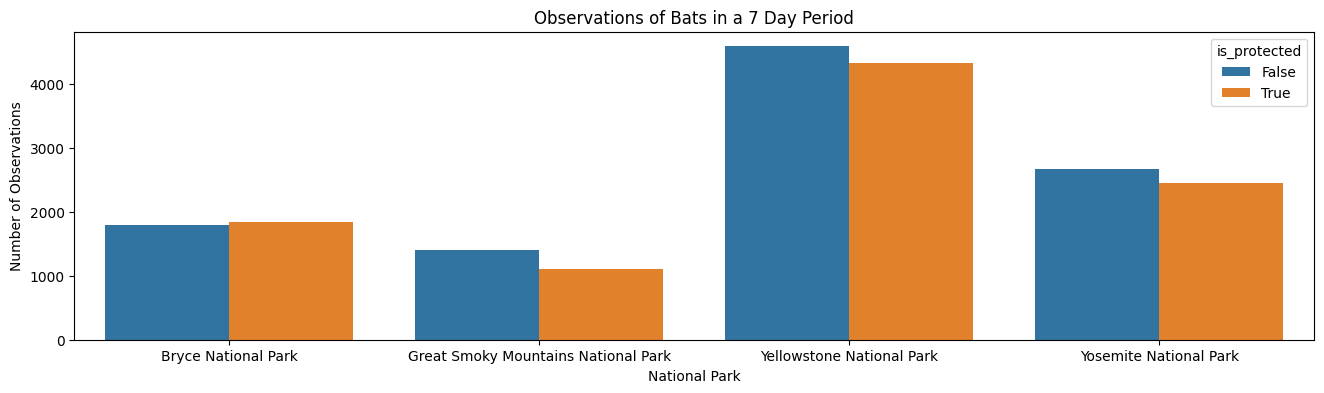

<Figure size 640x480 with 0 Axes>

In [106]:
# This plots the observations of bats and their protection
plt.figure(figsize=(16,4))
sns.barplot(x=protection_by_park.park_name, y=protection_by_park.observations, hue=protection_by_park.is_protected)
plt.xlabel('National Park')
plt.ylabel('Number of Observations')
plt.title('Observations of Bats in a 7 Day Period')
plt.show()
plt.clf()

# Questions to Answer

## What is the distribution of conservation_status for animals?
*

## Are certain types of species more likely to be endangered?
*

## Are the differences between species and their conservation status significant?
*

## Which species were spotted the most at each park?
*